### A Perceptual Discrimination Task to Study Decision Making

This is actual data from my lab, which was published here:

Nunez, M. D., Vandekerckhove, J., & Srinivasan, R. (2017). How attention influences perceptual decision making: Single-trial EEG correlates of drift-diffusion model parameters. Journal of Mathematical Psychology, 76(Part B), 117–130. https://doi.org/10.1016/j.jmp.2016.03.003

Human subject were asked to discriminate the spatial frequency of Gabor patches (as shown below), embeded in noise.  Task difficulty was controlled by the difficulty of the discrimination.  Two Gabors with more similar spatial frequencies are harder to discriminate, especially when noise is added.  In each of 34 participant, The experiment was performed in Easy, Medium, and Hard blocks each consisting of with decreasing differences between the Gabor spatial frequencies.  

![](spatialfrequency.png)



An experimental trial would look something like this. 

<p align="center">
  <img src="stimuli.png" alt="alt text" width="70%">
</p>


The datafile ReactionTimeData.csv is for use in this homework. You can load it into your notebook using pandas using pandas. There are 3 variables in the file: 

* Subject - indicates a numeric subject id 
* Experimental Condition - Easy, Medium, Hard 
* Correct - 1 if correct 0 if incorrect 
* ResponseTime  - time from stimulus presentation to decision in units of millisecond 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize

In [2]:
df = pd.read_csv('../data/ResponseTimeData.csv')
#I always like to dump info as soom as I load a dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11584 entries, 0 to 11583
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    11584 non-null  int64 
 1   Subject       11584 non-null  int64 
 2   Condition     11584 non-null  object
 3   Correct       11584 non-null  int64 
 4   ResponseTime  11584 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 452.6+ KB


In [3]:
#Since I dont know anything about this data, I will do some Exploratory Data Analysis (EDA)
#Lets see how many subjects are there
df['Subject'].nunique()
#Lets see how many trials per subject
df['Subject'].value_counts() 
#It varies a little bit.  Every subject did 360 trials, but I removed trials with no response or too rapid of a response

Subject
8     355
9     355
32    355
22    355
16    355
10    354
4     353
27    352
23    352
3     352
17    352
28    352
15    352
6     351
31    350
13    350
11    348
18    346
24    345
19    345
20    344
7     344
25    343
26    342
5     340
30    340
34    338
29    338
12    336
2     332
33    329
14    317
21    308
1     204
Name: count, dtype: int64

In [4]:
#Lets see how many conditions are there
df['Condition'].value_counts()
#Looks like there are 3 conditions - Easy, Medium, Hard


Condition
Hard      3893
Medium    3872
Easy      3819
Name: count, dtype: int64

In [5]:
#Lets see how many correct and incorrect trials are there
df['Correct'].value_counts()
#1 is correct 0 is incorrect 

Correct
1    9105
0    2479
Name: count, dtype: int64

There is a lot of values of response time, and they are continuous.  We will make a histogram to take a look at it. 

<Axes: xlabel='ResponseTime', ylabel='Count'>

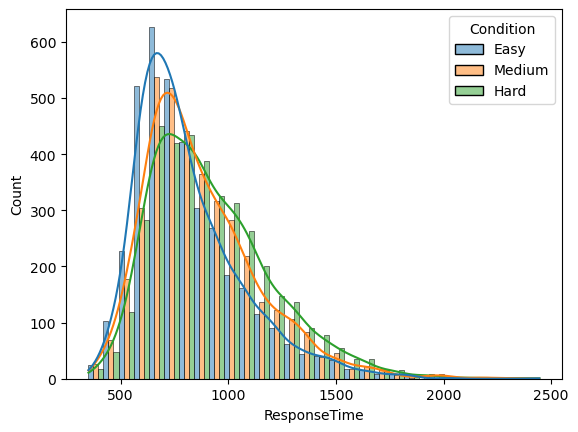

In [6]:
sns.histplot(data=df, x='ResponseTime', bins=30, hue='Condition', hue_order = ['Easy','Medium','Hard'],kde=True,multiple='dodge')

* Lets compute some overall statistics 

In [7]:
# I can do this inside pandas actually. 
accuracy = df['Correct'].mean()
print(f'Overall accuracy is {accuracy*100:.2f}%')

Overall accuracy is 78.60%


In [8]:
mean_rt = df['ResponseTime'].mean()
print(f'Overall mean response time is {mean_rt:.1f} ms')

Overall mean response time is 868.7 ms


* This is the pandas way of grouping the data and getting separate means

In [9]:
mean_rt_by_condition = df.groupby('Condition')['ResponseTime'].mean()
mean_acc_by_condition = df.groupby('Condition')['Correct'].mean()
print('Mean Response Time by Condition:')
print(mean_rt_by_condition)
print('Mean Accuracy by Condition:')
print(mean_acc_by_condition)

Mean Response Time by Condition:
Condition
Easy      812.957842
Hard      920.328282
Medium    871.684659
Name: ResponseTime, dtype: float64
Mean Accuracy by Condition:
Condition
Easy      0.884263
Hard      0.671462
Medium    0.804236
Name: Correct, dtype: float64


* I want to look at it by condition, and I dont want to hassle dealing with pandas syntax

In [10]:
rt = np.array(df['ResponseTime'])
correct = np.array(df['Correct'])
condition = np.array(df['Condition'])

In [11]:
condition_labels = ['Easy','Medium','Hard']
#mean_rt = [np.mean(rt[condition==cl]) for cl in condition_labels]
#mean_acc = [np.mean(correct[condition==cl]) for cl in condition_labels]
mean_rt = dict()
std_rt = dict()
mean_acc = dict()
for cl in condition_labels:
    mean_rt[cl] = np.mean(rt[condition==cl])
    std_rt[cl] = np.std(rt[condition==cl])
    mean_acc[cl] = np.mean(correct[condition==cl])



In [12]:
print('Mean Accuracy by condition:')
print(mean_acc)

Mean Accuracy by condition:
{'Easy': np.float64(0.8842628960460853), 'Medium': np.float64(0.8042355371900827), 'Hard': np.float64(0.6714615977395325)}


In [13]:
print('Mean RT by condition:')
print(mean_rt)
print('Std RT by condition:')
print(std_rt)

Mean RT by condition:
{'Easy': np.float64(812.9578423671118), 'Medium': np.float64(871.6846590909091), 'Hard': np.float64(920.328281530953)}
Std RT by condition:
{'Easy': np.float64(248.6647264233954), 'Medium': np.float64(267.98087231333045), 'Hard': np.float64(281.14363089159184)}


### MLE Estimate of a Normal Distribution 

If we have a set of samples $X$ = {$x_n$\}, n = 1,..,N that we wish to fit to a normal distribution, we have to develop an expression for the the Likelihood. 

The Normal distribution $\mathcal{N}(\mu,\sigma^2)$ has probability density 

$$ \mathcal{p}(x |\mu,\sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}e^{\frac{-(x-\mu)^2}{2\sigma^2}} $$
where $\mu$ is the mean and $\sigma^2$ is the variance or standard deviation squared.  

The Likelihood for the set of observation \{$x_n$\}, n = 1,..N is the product of the normal density for each observation, 

$$L(\mu,\sigma) = p(\{x_n\}|\mu,\sigma) = \prod_{n=1}^N p(x_n|\mu,\sigma)$$
$$ln(L(\mu,\sigma)) = ln(p(\{x_n\}|\mu,\sigma)) =  \sum_{n=1}^N ln(p(x_n|\mu,\sigma))$$

* The maximum likelihood estimate is 
$$ \mu = \frac{1}{N} \displaystyle\sum_{n=1}^N{x_n}  = \bar{X}  $$
$$ \hat{\sigma}^2= \frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^2 = s_X^2 $$

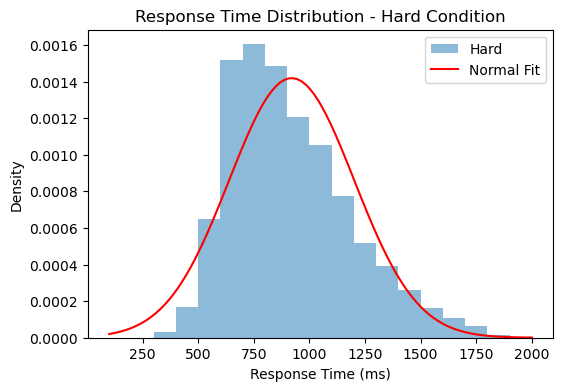

In [14]:
plt.figure(figsize=(6,4))
plt.hist(rt[condition=='Hard'], np.arange(100,2000,100), alpha=0.5, label='Hard',density =True)
normal = stats.norm(loc=mean_rt['Hard'], scale=std_rt['Hard'])
x = np.linspace(100,2000,100)
plt.plot(x, normal.pdf(x), 'r-',label = "Normal Fit")
plt.xlabel('Response Time (ms)')
plt.ylabel('Density')
plt.title('Response Time Distribution - Hard Condition')
plt.legend()
plt.show()

Lets write down the likelihood for a normal distribution using `norm.pdf` 

In [15]:
def negloglikenormal(params):
    ''' Please note that this function uses a global variable called data, which is the data you are fitting
        params is a list or array with two elements - mean and standard deviation
    '''
    mu = params[0]
    sigma = params[1]
    N = len(data)
    negloglike = np.sum(-np.log(stats.norm(mu,sigma).pdf(data)))
    return negloglike

Even though we know the correct answer we could in fact use this negative log-likelihood to search for the best fit parameters.  We need this function, and the `minimize` function from `scipy.optimize` 

In [16]:
data = rt[condition=='Hard'] #global variable used in the function above
bnds = ((0,2000),(0,500)) #bounds for mean and standrd deviation
paramfit = minimize(negloglikenormal,(1000,250),bounds = bnds); #initial guess is (1000,250)

In [17]:
print('Fitted parameters for Hard condition:')
print(f'Mean: {paramfit.x[0]:.1f}, Std: {paramfit.x[1]:.1f}')
print(f'Function value (Negative Log Likelihood): {paramfit.fun:.1f}')

Fitted parameters for Hard condition:
Mean: 920.3, Std: 281.1
Function value (Negative Log Likelihood): 27476.0


### MLE is a powerful method. 

* If I choose a useful, meaningful **probability model** $P(X|\theta)$, 

* And if I can write down a **likelihood** as the product of the probability of observing each observation of data. 

* Then I can find the **parameters** of the probability model that maximize the likelihood.  

* In practice, I will work with **log-likelihood** because by taking a log, I replce the product of probabilities with the sum of log(probability). The maximimum of log-likelihood is at the same parameter values as the maximum of likelihood. 

* In practice, I will often work with **negative log-likelihood** because I will find myself using optimization to tools that are designed to find the minimum of a function. 



### A hypothesis about the decision making process 

* Assume a model that samples evidence in discrete time windows. The evidence
obtained in each time window will favor one of the two alternatives (a "nudge").

* Each sample represents a nudge toward one decision or another. The magnitude of that nudge reflects how much information is acquired in that single sample.

* The nudge would then be added to the sum of previous nudges, moving a
decision variable towards one or the other alternative. (An alternative view is that
there are two decision variables involved in a race)

* A decision is made when the decision variable crosses a boundary (In a race or
competing accumulator model, one of the two accumulators crosses the
boundary).

### Random Walk Models 

<p align="center">
  <img src="randomwalker.png" alt="alt text" width="30%">
</p>

Random walk models originated in physics and chemistry (e.g., Brownian motion
of a gas)
They are used in psychology and neuroscience.
They are also used in economics and finance.
Ramesh Srinivasan
Cognitive Sciences
Lecture 2

### Random Walk Models 

* Random walk process starts at $Z(0)$ (This is an important variable that
expresses bias, i.e., intrinsic preference for one choice over the other!)
* At each time point t, the walker takes a step $X(t)$. 
* $X(t)$ can be any positive or negative number randomly drawn from some distribution, e.g., $\mathcal{N}(\mu,\sigma^2)$
* The evidence, i.e. position of the walker, after 1 step is defined as: 

$Z(1) = Z(0) + X(1)$

* The evidence, i.e. position of the walker, after 2 steps is defined as:

$Z(2) = Z(1)+ X(1) = Z(0) + X(1) + X(2)$

* More generally, after T steps

$$ Z(T) = Z(0) + \sum_{t = 0}^T X(t) $$


### Random Walker 

* In our example of the drunken walker, let's assume they start at the middle of the table. We will call that position $Z = 0$ 

* The two edges of the table are then at $Z = \pm B$

* Each step could be equally to the left or right, so we can reasonably assume that steps are equally likely to be to the left or right.  

$$X \sim \mathcal{N}(0,\sigma^2)$$

* The steps taken by the drunk **accumulate** and there is some possibility the drunk will fall-off one side of the table. 


### Relationship to Decision Making 

* Our narrative of the random walker, provides a useful metaphor for a model of decision making. 

* After figure-ground segregation, a neural representation of the stimulus in an experiment is available in the brain.

* In a two-alternative decision making task, the stimulus must be classified as being from one of two classes. For example, high or low spatial frequency. 

* At each time step, a sample of evidence can obtained from the neurons that represent the stimulus.  Since there is actual information in the stimulus,this evidence will (on average) favor the correct decision.  But these samples are noisy, and could providence evidence $X$ for the wrong decision

$$ X(t) \sim \mathcal{N}(d,\sigma^2) $$

* Here $d$ represents the information available in the stimulus. 

* The boundary B represents a criterion for how much accumulated evidence $Z$ is needed to select one decision. There is a boundary at $+B$ and a boundary at $-B$.  We can have these boundaries represent the two decisions, but its better to follow a convention that d is always positive, and $+B$ is correct decision and $-B$ is the incorrect decision. 

* The sample on which $Z > B$ or $Z < -B$ triggers a motor response. 
* We can introduce the notion of bias by starting the walks $X(0) \neq 0$. This represents a prior belief by the decision maker that one choice is correct.  

### Drift-Diffusion Model

![alt text](DDM.png)

### Shifted Wald Distribution 
<p align="center">
  <img src="sw.png" alt="alt text" width="50%">
</p>

* In this simplified diffusion, we simply focus on the correct (or incorrect) trials separately, and assume there is only one boundary.  
* In this process model, there are 3 parameters:
    * $\theta$ which is referred to as shift which is nondecision time.
    * $\alpha$ which is the boundary separation or caution.
    * $\gamma$ which is drift rate or the rate of evidence accumulation.

![alt text](sw_shapes.png)

$$f(X|\gamma,\alpha,\theta) = \frac{\alpha}{\sqrt{2\pi(X-\theta)^3}}e^{-\frac{|\alpha - \gamma(X - \theta)|^2}{2(X-\theta)}}$$

### Shifted-wald interpretation 

* The shifted Wald model has a clear link to the process that generated the data. Each of the parameters has a meaning.

* The shift parameter $\theta$ is related to the time outside of "decision making", i.e.,
evidence accumulation process. This is the time for sensory processing and motor
response.

* The boundary parameter $\alpha$ reflect the caution of the subject - how much
information do they need to make a decision.

* The drift parameter $\gamma$ reflect the rate of information accrual, or difficulty of the task.

* The main "weakness" of the shifted Wald model is that it can only make use of correct
trials and completely ignores the incorrect trials.

* The full drift-diffusion model maybe a better model as it incorporates the incorrect trials. 

* Which model to fit depends on the nature of the task and the data available. For
example, in tasks with very high accuracy, the shifted Wald model may be a better
model, as there are insufficient incorrect trials to fit the drift-diffusion model.

### Framing Your Hypothesis Quantitatively in a Model

<p align="center">
  <img src="spatialfrequency.png" alt="alt text" width="20%">
</p>

* Consider the spatial frequency discrimination task whose data you will look at.

* The data show that as the discrimination becomes more difficult (difference in spatial
frequency becomes smaller), accuracy is lower, and response time increases for accurate trials.

* Using the single diffusion model (shifted-Wald) can we express some hypothesis about
the data:
    * The experiment was designed to manipulate drift rate by reducing the information available in the stimuli. As the spatial frequencies become closer there is less evidence to accumulate on each sample, so $\gamma$ should be smaller and response time increases.
    * However, keep in mind, since we used a block design there is always the possibility that boundary is varying with task difficulty as the subjects became more cautious when they find evidence accumulation is slower (task harder).

